In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

In [3]:
path = "data/"
file_name = ['chicago_2019.csv', 'chicago_2020.csv', 'chicago_2021.csv', 'chicago_2022.csv']
filenames =[path + file for file in file_name]
#print(filenames)

""" 
    Read Me: Basic File Merger, to combine the 2019-2022 census data
    Requires: file path list
"""
def fileMerger(path):
    df1 = pd.read_csv(path[0])
    df2 = pd.read_csv(path[1])
    df_merged = df1.merge(df2, how='outer')
    for file in path[2:]:
        temp = pd.read_csv(file)
        df_merged = df_merged.merge(temp, how='outer')
    return df_merged

df = fileMerger(filenames)

In [4]:
df.shape

(922148, 22)

In [5]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,24368,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
1,24369,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
2,24370,JC105864,01/05/2019 04:23:00 PM,012XX N ADA ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,2.0,24.0,01A,1167119.0,1908611.0,2019,09/01/2022 03:42:17 PM,41.904789,-87.661560,"(41.904788891, -87.66155984)"
3,24371,JC106397,01/06/2019 12:10:00 AM,014XX W 71ST PL,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,...,17.0,67.0,01A,1168078.0,1857336.0,2019,09/19/2022 03:41:05 PM,41.764065,-87.659515,"(41.764064647, -87.659514616)"
4,24372,JC107385,01/06/2019 10:23:00 PM,060XX W 63RD ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,13.0,64.0,01A,1137054.0,1862130.0,2019,09/01/2022 03:42:17 PM,41.777831,-87.773112,"(41.77783091, -87.773112387)"


In [6]:
# Converting Community Area Code to an Community Name
"""
This allows us to explore data much effectively, being able
to scrape further information outside of just a code, such as
exploring real estate property indices in each community, and
make inferences regarding average home sale price and its corresponding community.
"""
import requests
url = "https://www.chicagotribune.com/2002/12/04/chicago-communities-17/"
text = requests.get(url).text

In [7]:
tables = pd.read_html(url)
print("Found {} tables in {}".format(len(tables), url))

Found 4 tables in https://www.chicagotribune.com/2002/12/04/chicago-communities-17/


In [8]:
hash = {"Community Area" : ["nan", "nan"], "Community Name": ["NaN", "NaN"]}

In [9]:
community = tables[1]

for item in (community):
    # community index
    if(item == 0 or item == 2):
        for i in range(len(community[item])):
                community[item] = community[item].astype(float)
                hash['Community Area'].append(community[item][i])
    if(item == 1 or item == 3):
        for i in range(len(community[item])):
                community[item] = community[item].astype(str)
                #print(community[item][i])
                hash['Community Name'].append(community[item][i])


In [10]:
def applyName(x):
    for item in range(len(hash["Community Area"])):
        if x == hash["Community Area"][item]:
            return hash["Community Name"][item]
df["Community Name"] = df['Community Area'].apply(applyName)

In [11]:
df.index = pd.DatetimeIndex(df.Date)

In [12]:
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['DayOfMonth'] = df.index.day
df['DayOfYear'] = df.index.dayofyear
df['WeekOfMonth'] = df.DayOfMonth.apply(lambda x: (x-1) // 7+1)

In [13]:
import math
dayOfYear = list(df.index.dayofyear)
weekOfYear = [math.ceil(x / 7) for x in dayOfYear]
df['weekOfYear'] = weekOfYear

<function matplotlib.pyplot.show(close=None, block=None)>

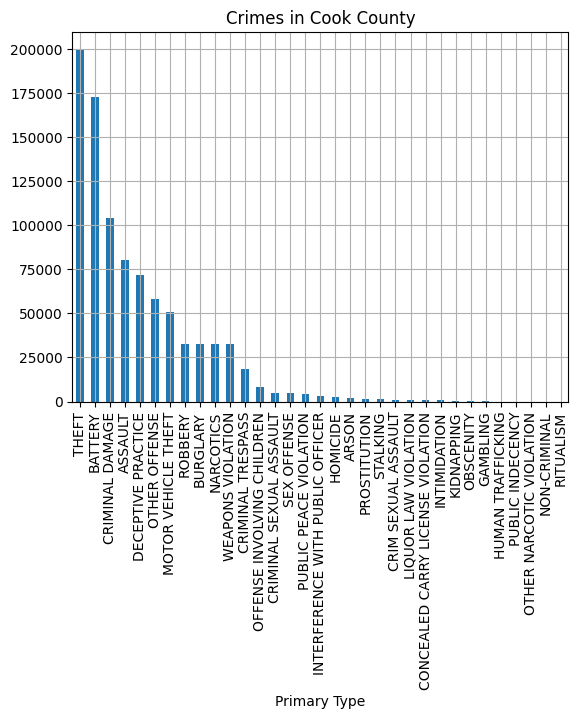

In [14]:
df['Primary Type'].value_counts().plot.bar()
plt.title("Crimes in Cook County")
plt.grid(True)
plt.show

We can clearly observe that crime categorized as "THEFT" has the highest occurences in Chicago, Cook County. 

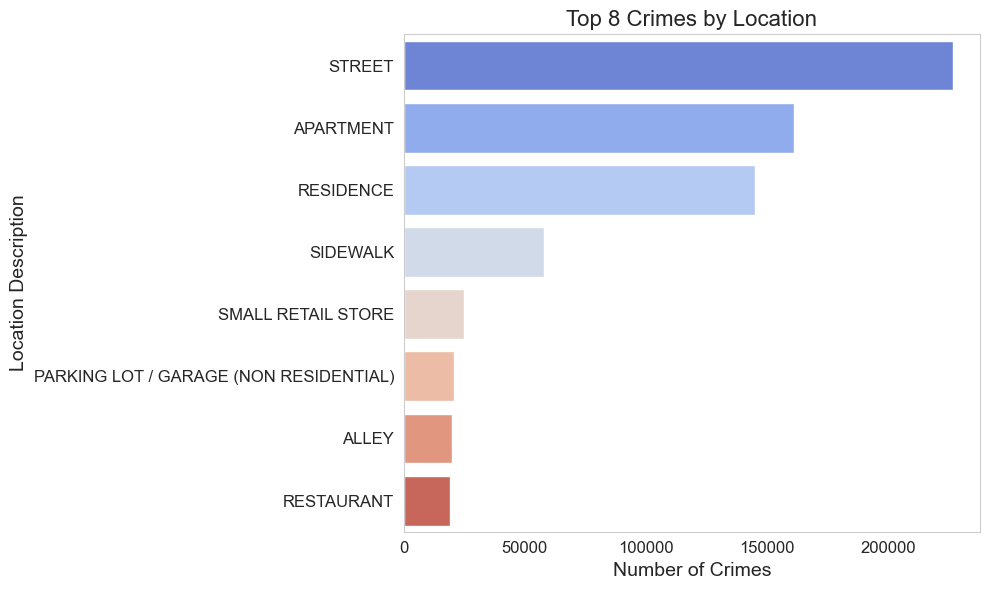

In [15]:
top_locations = df['Location Description'].value_counts().head(8)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
palette = sns.color_palette("coolwarm", len(top_locations))
sns.barplot(x=top_locations.values, y=top_locations.index, palette=palette)
# Customize the visualization
plt.title('Top 8 Crimes by Location', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=14)
plt.ylabel('Location Description', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Crimes are most frequently occuring in areas of residence within Chicago, Cook County. There could potentially be an observable correlation between crimes occuring within domestic cases, rather than by random occurence. Might look into investigating. 

In [16]:
def bar_plot(data, col):
    if data[col].dtype in ['object']:
        fig, ((axis1, axis2)) = plt.subplots(2, 1, figsize=(15,20))
        plot = df[['Arrest', col]].dropna()
        df1 = plot.loc[plot['Arrest'] == True]
        df2 = plot.loc[plot['Arrest'] == False]
        df1.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis1, title='Arrest: ' + col) 
        df2.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis2, title='NO Arrest: ' + col) 


In [17]:
def bar_plot(df, col, title_prefix=''):
    
    # CHECK TO SEE IF THE COLUMN IS PRESENT >> 
    if col in df.columns and df[col].dtype == 'object':
        plot_data = df[['Arrest', col]].dropna()
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))
        for i, arrest_status in enumerate([True, False]):
            temp_df = plot_data[plot_data['Arrest'] == arrest_status]
            count_series = temp_df[col].value_counts().nlargest(10)
            palette = sns.color_palette("rocket", len(count_series))
            sns.barplot(y=count_series.index, x=count_series.values, ax=axes[i], palette=palette)
            axes[i].set_title(f"{title_prefix}{'Arrest' if arrest_status else 'No Arrest'}: {col}")
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel(col)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Column '{col}' is not present or not categorical.")


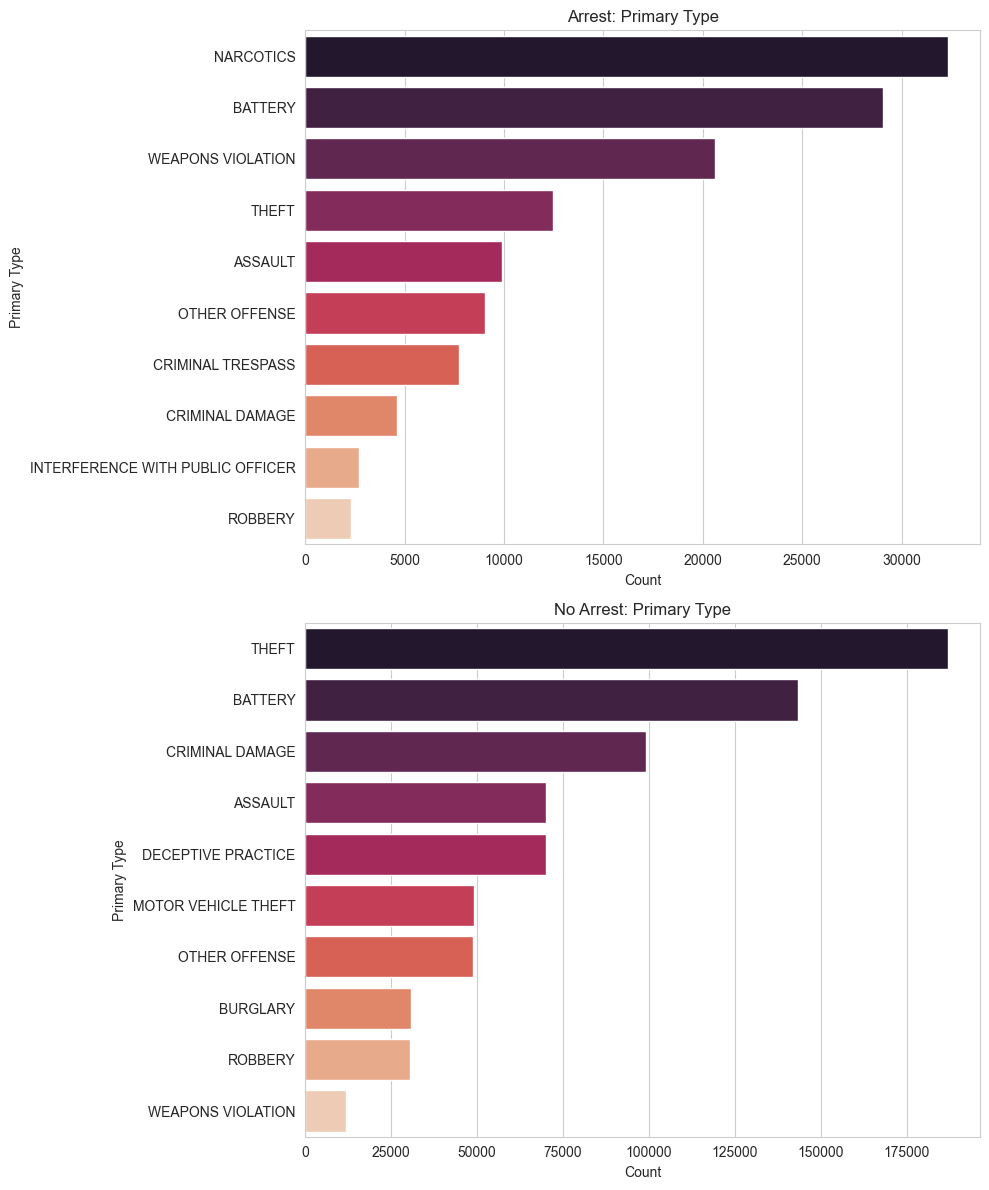

In [18]:
bar_plot(df, 'Primary Type')

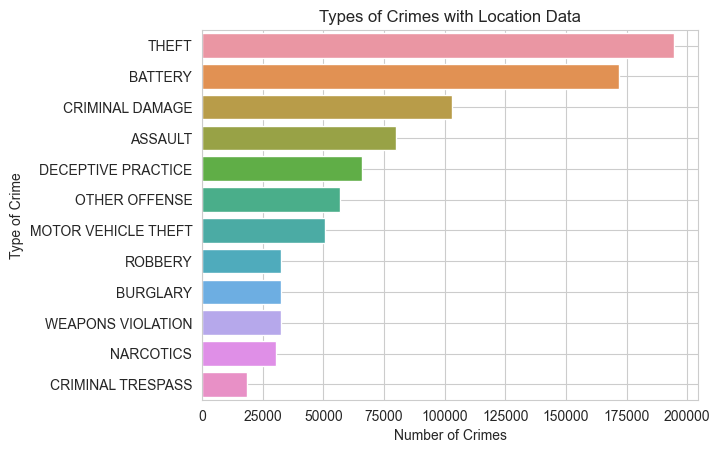

In [19]:
is_crimes = df[df["Location"].notnull()]
crime_counts = is_crimes.groupby("Primary Type").size().sort_values(ascending=False).head(12)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Types of Crimes with Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.grid(True)
plt.show()

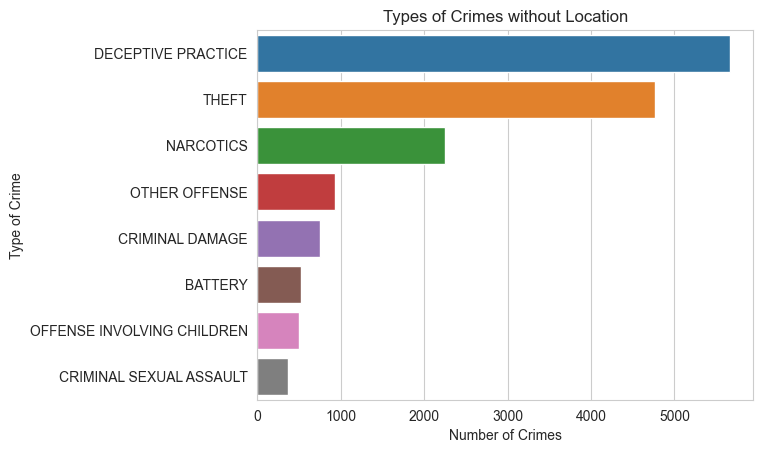

In [20]:
not_crime = df[df["Location"].isnull()]
crime_counts = not_crime.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Types of Crimes without Location")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

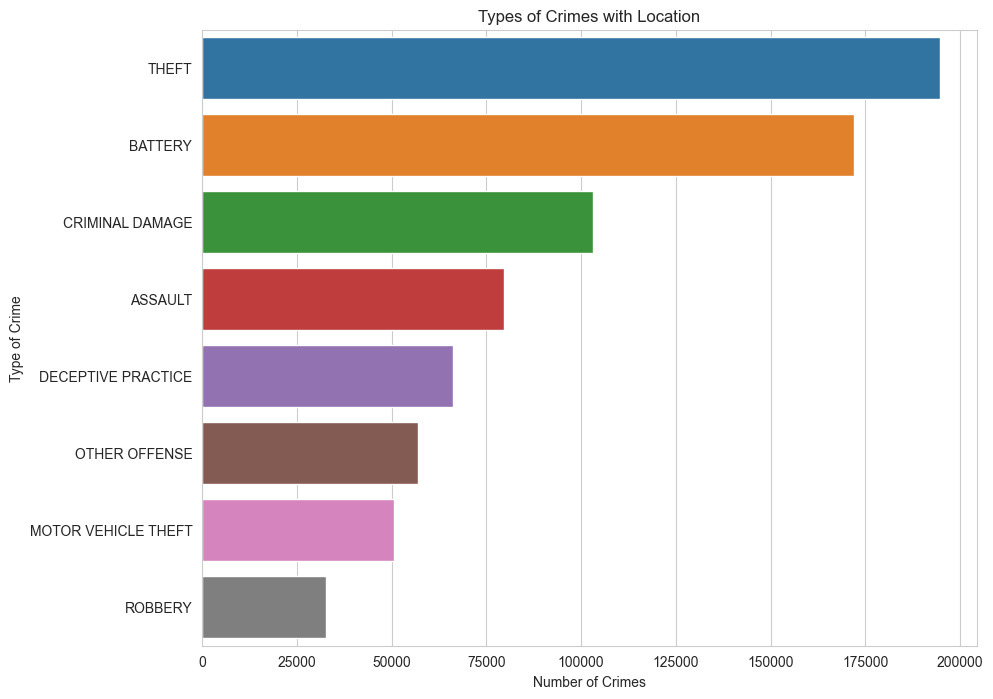

In [21]:
not_crime = df[df["Location"].isnull()==False]
not_crime = df[df["Location"].isnull()==False]
not_crime = not_crime.groupby("Primary Type").size().sort_values(ascending=False).reset_index(name='counts').head(8)
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
sns.barplot(data=not_crime, y="Primary Type", x="counts", ax=ax)
plt.title("Types of Crimes with Location")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

* Deceptive Practice
It's the crime where a person commits a practice when they have the intent to defraud another person and does any of the follow:
- Knowingly cause another person, by threat or deception, to execute a document/payment
- Dispose the victim of a property or incur a pecuniary oblogation
> This in turn makes sense, that it wouldn't have a location, given that most of these crimes are reported through online documentation, an idea would be that the crime occurs in wards with an higher overall income, who may be more suspect to being targeted by these fraudulent malpractices. 

In [22]:
df['Y Coordinate']

Date
2019-01-03 14:37:00    1871575.0
2019-01-03 14:37:00    1871575.0
2019-01-05 16:23:00    1908611.0
2019-01-06 00:10:00    1857336.0
2019-01-06 22:23:00    1862130.0
                         ...    
2022-03-11 21:00:00          NaN
2022-12-20 14:15:00          NaN
2020-04-23 08:00:00          NaN
2020-01-01 00:00:00          NaN
2022-09-01 10:00:00          NaN
Name: Y Coordinate, Length: 922148, dtype: float64

Text(0.5, 1.0, 'Crime Distribution per District')

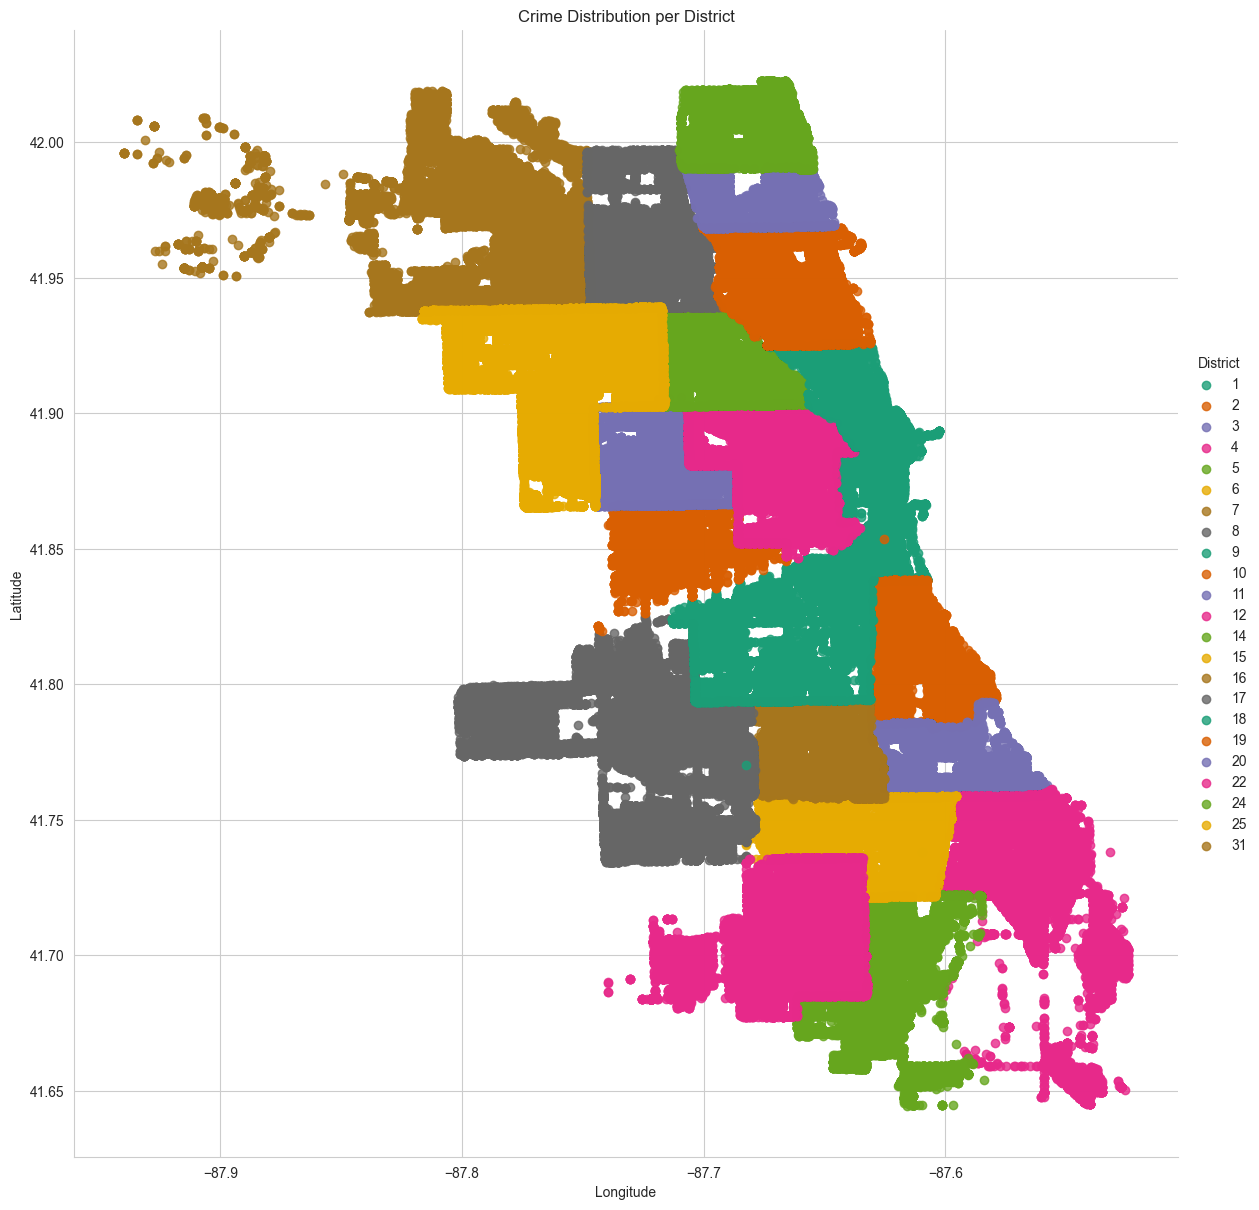

In [23]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="District",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per District")

Text(0.5, 1.0, 'Crime Distribution per Community Name')

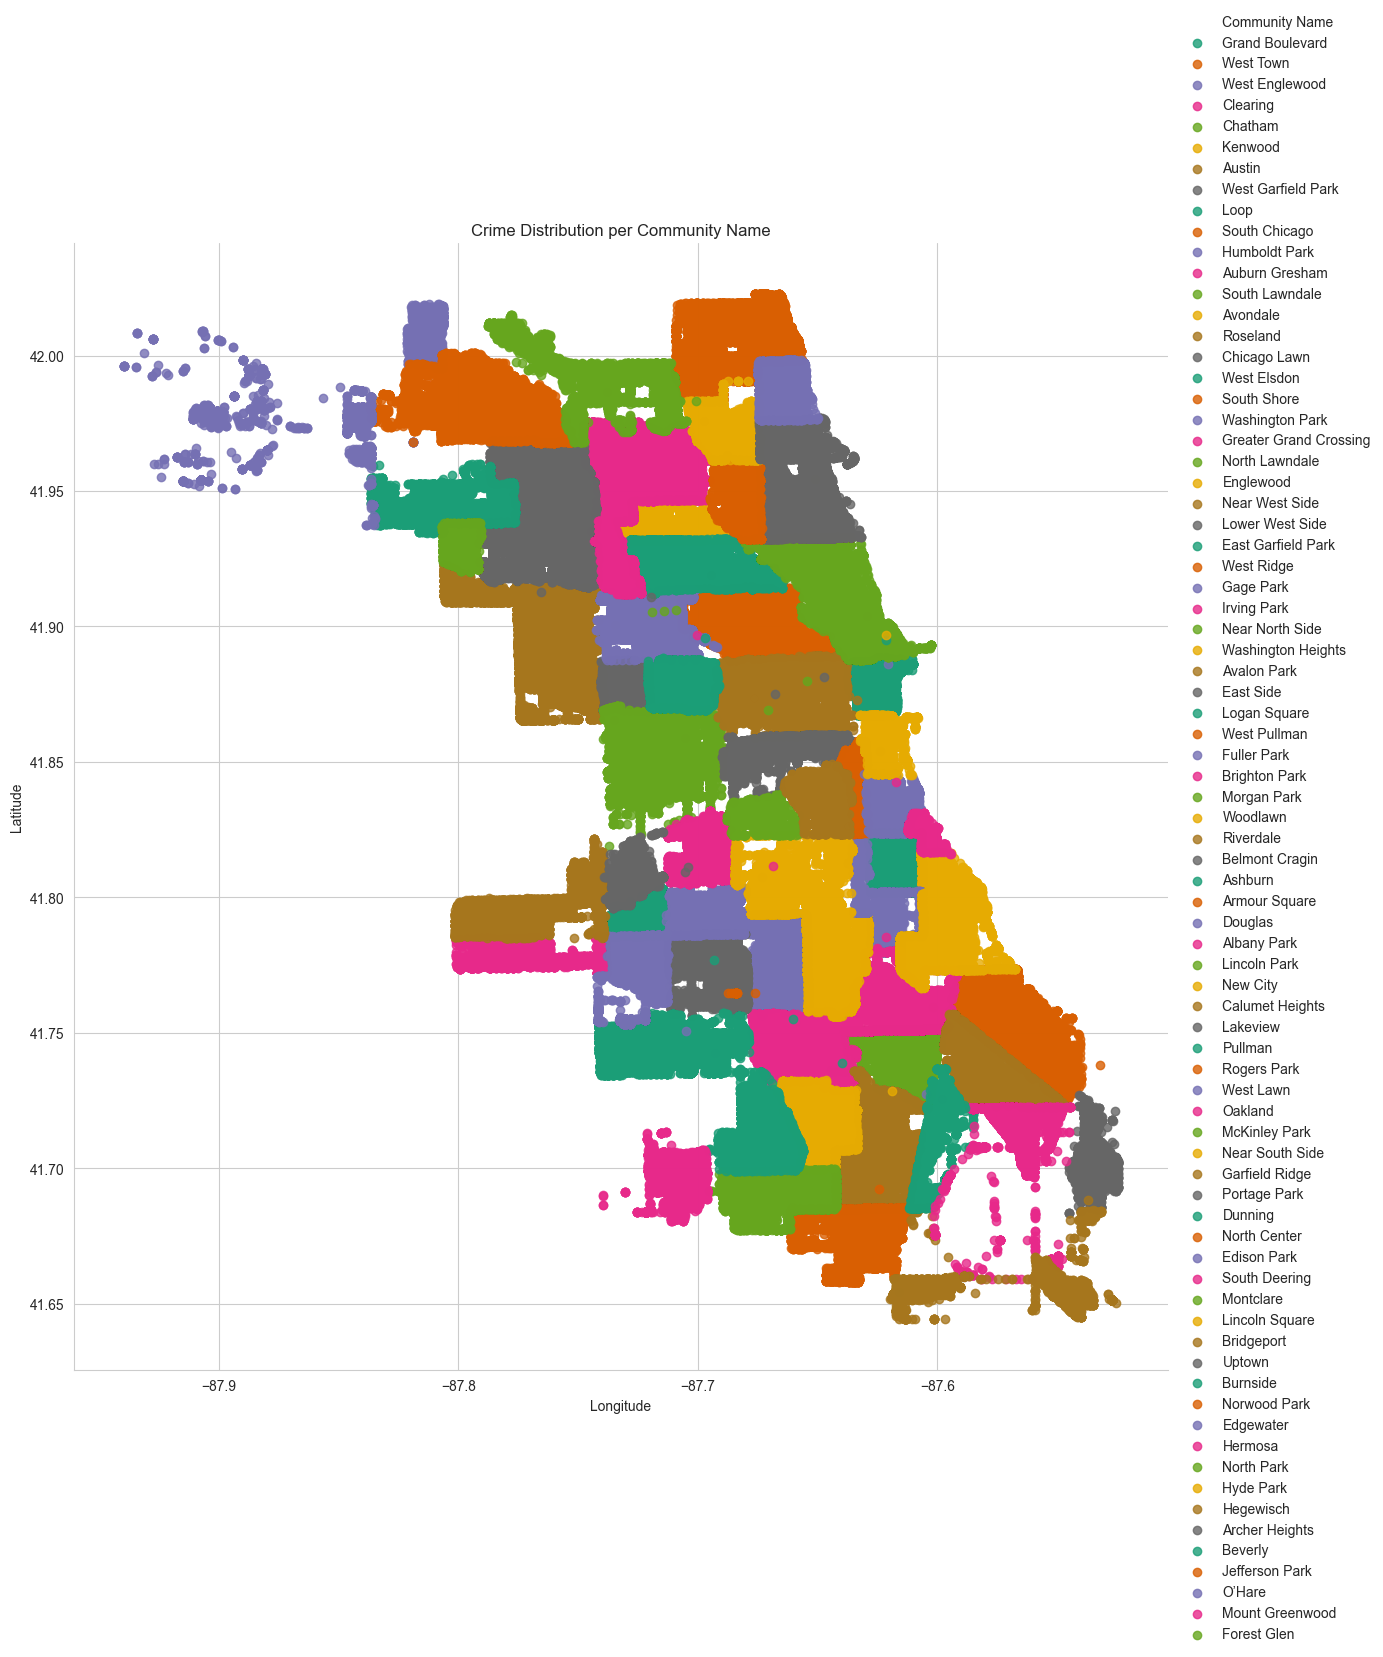

In [24]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="Community Name",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per Community Name")

**Data Preprocessing**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [26]:
df[['Ward', 'Latitude', 'Longitude', 'Month', 'Location Description']].isnull().sum()
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df.dropna(subset=['Location Description', 'Ward', 'Community Area'])
print(df.isnull().sum())

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
Community Name          0
Month                   0
DayOfWeek               0
DayOfMonth              0
DayOfYear               0
WeekOfMonth             0
weekOfYear              0
dtype: int64


In [27]:
df['Ward'] =  df['Ward'].astype("category").cat.codes
df['Arrest'] = df['Arrest'].astype(int)
df['Description'] = df['Description'].astype("category").cat.codes
df['Location Description'] = df['Location Description'].astype("category").cat.codes
df['Community Name'] = df['Community Name'].astype("category").cat.codes
target_col = ['Ward', 'Community Name', 'Community Area', 'Location Description'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = df[target_col]
X.shape
directory = ['Primary Type']
y = df[directory]
if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    from sklearn import metrics
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score}\n")

    if score < 60:
        df2 = df[df["Year"] == 2019]
        #print(df2.value_counts())

        X = df2[target_col]
        y = df2[directory]
        if X.shape[0] == y.shape[0]:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            score = metrics.accuracy_score(y_test, y_pred) * 100
            print(f"Accuracy of the KNN Classifier in this run was: {score}\n")

            #cm = pd.crosstab(y_test, y_pred, rownames=['Ward Actual'], colnames=['Ward Predicted'])
            #print(cm) #confusion matrix, should be really inaccurate


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this imbalanced dataset: 24.10882675316953



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this run was: 27.6404877368576



Clearly there is an issue here. Issues in the baseline accuracy, we might need to establish some baseline accuracy to compare our score performance to. Our precision of all values in between 0.25 through around 0.29 says that the model (K-Nearest Neighbor Classifier) is able to properly identify the correct crime type based upon ward description about ~27% of the time. This would definitely go back to the importance of understanding the various unique factors that ultimately impact the hindsight of why crime in general occurs. In the next model, I'm going to digest more into the learning, by classifying down to specific wards and doing analysis within each ward to see if our metrics score will change at all. Additionally, we will look into model recall. Happy coding!

In [28]:
test_df = df[df['Ward'].isin([42])]
target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    from sklearn import metrics
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score}\n")

Accuracy of the KNN Classifier in this imbalanced dataset: 36.449364493644936



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


# Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 101)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy:",(metrics.accuracy_score(y_test, y_pred)*100),"\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 43.21443214432144 



In [30]:
test_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Name', 'Month', 'DayOfWeek', 'DayOfMonth',
       'DayOfYear', 'WeekOfMonth', 'weekOfYear'],
      dtype='object')

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

"""test_df['Date'] = pd.to_datetime(df['Date'])
test_df['Hour'] = df['Date'].dt.hour
test_df['DayOfWeek'] = df['Date'].dt.dayofweek
test_df['Month'] = df['Date'].dt.month"""

features = ['DayOfWeek', 'Month', 'Latitude', 'Longitude', 'Location Description', 'Arrest', 'Domestic']
target = 'Primary Type' 
categorical_features = ['Location Description', 'Arrest', 'Domestic']
one_hot_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

X = test_df[features]
y = test_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)

scaler = StandardScaler(with_mean=False) 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=101, class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1 Score: {f1:.2f}")

Accuracy: 46.37%
F1 Score: 0.41


https://www.youtube.com/watch?v=RHGiXPuo_pI

**LSTM** Long Short Term Memory


In [48]:
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F #activation function
from torch.optim import Adam
import torch.optim as optim
import lightning as List
import pytorch_lightning as L 
from torch.utils.data import TensorDataset, DataLoader

In [45]:
#convert our test_df into data-time accordance
test_df = test_df.sort_index(ascending=True)
test_df.isnull().sum()
test_df.dtypes
test_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,Community Name,Month,DayOfWeek,DayOfMonth,DayOfYear,WeekOfMonth,weekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,11574868,JC126701,01/01/2019 12:00:00 AM,016XX N CLEVELAND AVE,1242,DECEPTIVE PRACTICE,151,136,0,False,...,41.911272,-87.641025,"(41.911272283, -87.641024702)",38,1,1,1,1,1,1
2019-01-01 01:00:00,11554161,JC101878,01/01/2019 01:00:00 AM,022XX N LINCOLN AVE,0890,THEFT,204,25,0,False,...,41.922751,-87.644994,"(41.922750548, -87.644994062)",38,1,1,1,1,1,1
2019-01-01 02:44:00,11552800,JC100200,01/01/2019 02:44:00 AM,018XX N LINCOLN AVE,0910,MOTOR VEHICLE THEFT,132,161,0,False,...,41.915663,-87.635077,"(41.915662706, -87.635076607)",38,1,1,1,1,1,1
2019-01-01 04:43:00,11552848,JC100341,01/01/2019 04:43:00 AM,005XX W EUGENIE ST,0486,BATTERY,179,35,0,True,...,41.912832,-87.642022,"(41.912831524, -87.642021866)",38,1,1,1,1,1,1
2019-01-01 12:00:00,11772930,JC366930,01/01/2019 12:00:00 PM,014XX N LAKE SHORE DR,2826,OTHER OFFENSE,217,119,0,True,...,41.908521,-87.625933,"(41.908521146, -87.625933413)",47,1,1,1,1,1,1


LSTM's are great for sequential data.

In [102]:
df['weekOfYear']

Date
2019-01-03 14:37:00     1
2019-01-03 14:37:00     1
2019-01-05 16:23:00     1
2019-01-06 00:10:00     1
2019-01-06 22:23:00     1
                       ..
2022-12-27 00:00:00    52
2022-12-27 14:00:00    52
2022-12-28 14:30:00    52
2022-08-29 00:00:00    35
2022-02-01 13:00:00     5
Name: weekOfYear, Length: 901395, dtype: int64

In [118]:
df= df.rename(columns={"Date": "DateTime"})
daily_crime_counts = df.groupby(['weekOfYear', 'Year']).size().reset_index(name='Crime Count')
daily_crime_counts = daily_crime_counts.sort_index(ascending=False)
daily_crime_counts.head(10)


,weekOfYear,Year,Crime Count
211,53,2022,722
210,53,2021,522
209,53,2020,966
208,53,2019,540
207,52,2022,3785
206,52,2021,3035
205,52,2020,3211
204,52,2019,4322
203,51,2022,4148
202,51,2021,3443


## Begin to Look into Crime Counts by Day
It is important to first reduce the "noise" that exists in the Crime Count data, showing high fluctuation, making it quite hard to interpret. To "normalize" this issue in a way, we will be using the rolling method with the window set to 4 (window size) essentially converting the weekly data into a 4-day window. 
- First Window = (x + y + z) / n = ROLLING
- Move Next =  x bygone, (y + z + e) / n = NEW ROLLING
- Next = x, y bygone, (z + e + l) / n = UPDATED


In the context of our crime data, the rolling mean would smooth out short-term fluctuations and highlight longer-term trends in crime occurrences. It's often used in time series analysis to help identify trends and cycles.

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000')])

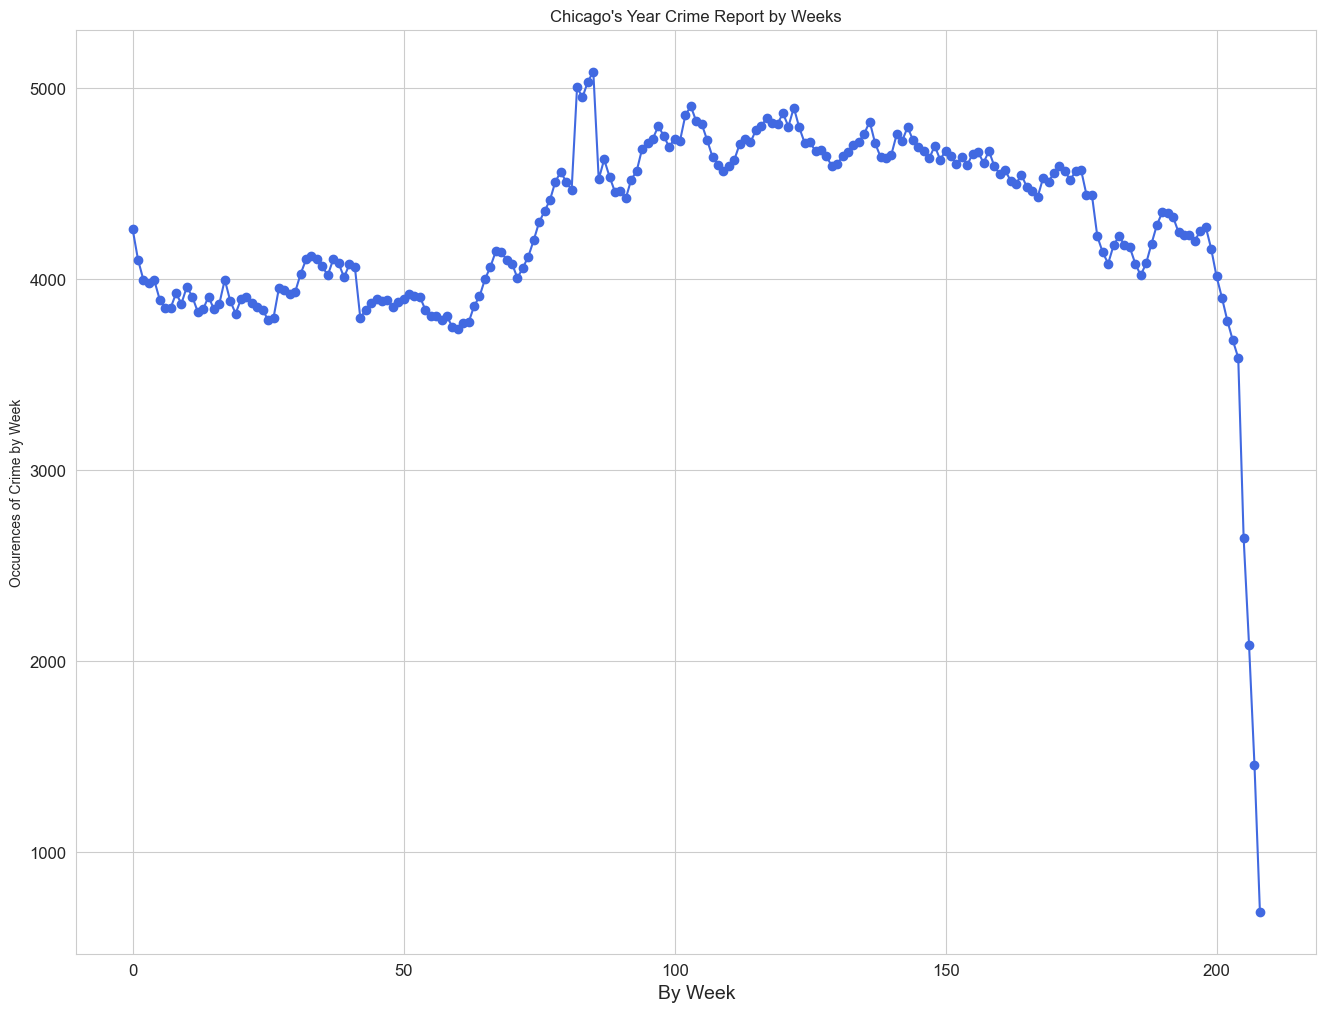

In [123]:
daily_crime_counts["Crime Count"]
plt.figure(figsize=(16,12))
rolling_mean = daily_crime_counts['Crime Count'].rolling(window=4).mean()
plt.plot(rolling_mean, color="royalblue", label="Price", marker="o")
plt.xlabel("By Week", fontsize=14)
plt.ylabel("Occurences of Crime by Week")
plt.title("Chicago's Year Crime Report by Weeks")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


In [128]:
daily_crime_counts['Crime Count Rolling Mean'] = daily_crime_counts['Crime Count'].rolling(window=4).mean()
daily_crime_counts['Crime Count Rolling Mean']
daily_crime_counts.isnull().sum()
daily_crime_counts.dropna(subset="Crime Count Rolling Mean")

,weekOfYear,Year,Crime Count,Crime Count Rolling Mean
208,53,2019,540,687.50
207,52,2022,3785,1453.25
206,52,2021,3035,2081.50
205,52,2020,3211,2642.75
204,52,2019,4322,3588.25
...,...,...,...,...
4,2,2019,4642,3992.75
3,1,2022,3333,3980.00
2,1,2021,3701,3994.50
1,1,2020,4726,4100.50


In [129]:
target_col = "Crime Count Rolling Mean"
from sklearn.preprocessing import MinMaxScaler
sc_data = MinMaxScaler(feature_range=(0,1))
sc_response = MinMaxScaler(feature_range=(0,1))

response_scaled = sc_response.fit_transform(daily_crime_counts[[target_col]])
data_set_scaled = sc_data.fit_transform(daily_crime_counts.loc[:, daily_crime_counts.columns != target_col])
print(data_set_scaled.shape)

data_set_scaled_new = []
for i in range(len(data_set_scaled)):
    data_set_scaled_new.append([])

    data_set_scaled_new[i] = np.append(data_set_scaled[i], response_scaled[i])
    # print(data_set_scaled_new[i])

data_set_scaled_new =np.asarray(data_set_scaled_new)
print(data_set_scaled_new)
#print(data_set_scaled_new.shape)

(212, 3)
[[1.         1.         0.03653635        nan]
 [1.         0.66666667 0.                nan]
 [1.         0.33333333 0.08111071        nan]
 [1.         0.         0.00328827 0.        ]
 [0.98076923 1.         0.59609061 0.17410334]
 [0.98076923 0.66666667 0.45907928 0.31694424]
 [0.98076923 0.33333333 0.49123128 0.44455181]
 [0.98076923 0.         0.69419072 0.65952367]
 [0.96153846 1.         0.66240409 0.68015688]
 [0.96153846 0.66666667 0.53361345 0.70334792]
 [0.96153846 0.33333333 0.57946657 0.73080202]
 [0.96153846 0.         0.77603215 0.7562667 ]
 [0.94230769 1.         0.76909024 0.78946172]
 [0.94230769 0.66666667 0.6172817  0.8154948 ]
 [0.94230769 0.33333333 0.56302521 0.81037913]
 [0.94230769 0.         0.7394958  0.79901097]
 [0.92307692 1.         0.79082938 0.80577502]
 [0.92307692 0.66666667 0.61764706 0.80588871]
 [0.92307692 0.33333333 0.57197662 0.8086739 ]
 [0.92307692 0.         0.79722324 0.82663559]
 [0.90384615 1.         0.80617464 0.83141022]
 [0.

In [ ]:
## WORK ON FORECASTING 

In [65]:
class LSTM(L.LightningModule):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def lstm_unit(self, input_value, long_memory, short_memory):
        # make a forward pass through unrolled LSTM
        long_pct = torch.sigmoid((short_memory * self.wlr1) +
                                 (input_value * self.wlr2) +
                                 self.blr1) #bias coefficient
        
        potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) +
                                      (input_value * self.wpr2) +
                                      self.bpr1)
        
        potential_memory = torch.tanh((short_memory * self.wp1) +
                                      (input_value * self.wp2) +
                                      self.bp1)
    
        updated_long_memory = ((long_memory * long_pct) +
                               (potential_remember_percent * potential_memory))
        
        output_pct = torch.sigmoid((short_memory * self.wo1) +
                                   (input_value * self.wo2) +
                                   self.bo1)
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_pct

        # return updated long/short term memory trained
        return([updated_long_memory, updated_short_memory])
    
    def forward(self, input):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, (hn, cn) = self.lstm(input)
        # Select the output of the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out



    def configure_optimizers(self):
        # configure adam optimizer
        return optim.Adam(self.parameters(), lr=0.001)
    
    def trainining_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = nn.functional.mse_loss(output_i, label_i)
        self.log("train_loss", loss)
        return loss

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#success

(7802, 7)
(1951, 7)
(7802,)
(1951,)
